AMASS is a database which is ready to allow deep learning on it. However, it consists of human body parameters instead of images, manipulating the surface mesh of the [SMPL+H body model].

The steps involved in training the DNN with the AMASS data are

- transform the compressed AMASS *.npz files to Pytorch readable *.pt files
- apply the data augmentations on the AMASS data and save them as *.hdf5 file
- convert the *.hdf5 to *.pt


Dependencies to run this notebook:
- [Human Body Prior](https://github.com/nghorbani/human_body_prior)
- [PyTorch>=1.1.0](https://pytorch.org/)
- [PyTables](https://www.pytables.org/usersguide/installation.html)
- [tqdm](https://pypi.org/project/tqdm/2.2.3/)
- pyrender==0.1.39
- configer
- pyglet

In [12]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import sys, os
import torch
import numpy as np

In [11]:
import shutil, sys
from torch.utils.data import Dataset
import glob
from datetime import datetime
import torch
from torch.utils.data import DataLoader
import tables as pytables
from tqdm import tqdm

In [5]:
from human_body_prior.tools.omni_tools import makepath, log2file
from human_body_prior.tools.omni_tools import copy2cpu as c2c
from human_body_prior.tools.omni_tools import euler2em, em2euler

download the body data npz files from https://amass.is.tue.mpg.de/datasets. 

Uncompress them at your desired location.

initialize the amass_dir where the input files are located and the initialize the work_dir where the output files are then saved.

In [20]:
amass_dir = "D:/OneDrive - Jacobs University/DS projects/Image Processing Project/amass-master/data/"

work_dir = 'D:/OneDrive - Jacobs University/DS projects/Image Processing Project/amass-master'

logger = log2file(os.path.join(work_dir, '.log'))
logger('[V1_SV1_T1] AMASS Data Preparation Began.')
logger('Initial use of standard AMASS dataset preparation pipeline ')

[V1_SV1_T1] AMASS Data Preparation Began.
 Initial use of standard AMASS dataset preparation pipeline 


Now you have to specify data splits for train/validation/test. Below is the recommended data splits by AMASS
for train/validation/test that chooses data for each split from non-overlapping datasets. 
One reason is to avoid similarity of markersets used for the original data.

In [9]:
amass_splits = {
    'vald': ['HumanEva', 'SFU', 'MPI_mosh'],
    'test': ['Transitions_mocap', 'SSM_synced'],
    'train': ['ACCAD', 'TCD_handMocap', 'TotalCapture', 'TCD_handMocap']
}
amass_splits['train'] = list(set(amass_splits['train']).difference(set(amass_splits['test'] + amass_splits['vald'])))

In [13]:
amass_splits = {
    'vald': ['SFU'],
    'test': ['Transitions_mocap'],
    'train': ['ACCAD', 'TCD_handMocap']
}
amass_splits['train'] = list(set(amass_splits['train']).difference(set(amass_splits['test'] + amass_splits['vald'])))

Now we have tools in place to run the preparation code:

In [24]:
prepare_amass(amass_splits, amass_dir, work_dir, logger=logger)

Stage I: Fetch data from AMASS npz files
randomly selecting data points from SFU.
  2%|█▉                                                                                 | 1/44 [00:00<00:05,  8.37it/s]

 11%|█████████▍                                                                         | 5/44 [00:00<00:03, 10.70it/s]

 16%|█████████████▏                                                                     | 7/44 [00:00<00:03,  9.54it/s]

 20%|████████████████▉                                                                  | 9/44 [00:00<00:04,  7.02it/s]

 23%|██████████████████▋                                                               | 10/44 [00:01<00:04,  7.45it/s]

 30%|████████████████████████▏                                                         | 13/44 [00:01<00:04,  6.34it/s]

 32%|██████████████████████████                                                        | 14/44 [00:01<00:04,  6.76it/s]

 36%|█████████████████████████████▊                                                    | 16/44 [00:01<00:03,  7.53it/s]

 39%|███████████████████████████████▋                                                  | 17/44 [00:02<00:03,  6.75it/s]

 52%|██████████████████████████████████████████▊                                       | 23/44 [00:02<00:02,  8.62it/s]

 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:03<00:04,  4.46it/s]

 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:03<00:02,  5.68it/s]

 66%|██████████████████████████████████████████████████████                            | 29/44 [00:03<00:02,  6.77it/s]

 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:04<00:01,  8.42it/s]

 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:04<00:00,  8.62it/s]

 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:04<00:00,  9.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:04<00:00, 10.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.52it/s]
randomly selecting data points from Transitions_mocap.
  0%|                                                                                          | 0/110 [00:00<?, ?it/s]

  3%|██▏                                                                               | 3/110 [00:00<00:08, 11.96it/s]

  5%|███▋                                                                              | 5/110 [00:00<00:09, 11.10it/s]

  7%|█████▉                                                                            | 8/110 [00:00<00:10,  9.96it/s]

  8%|██████▋                                                                           | 9/110 [00:00<00:11,  8.56it/s]

 10%|████████                                                                         | 11/110 [00:01<00:10,  9.14it/s]

 14%|███████████                                                                      | 15/110 [00:01<00:09,  9.68it/s]

 15%|████████████▌                                                                    | 17/110 [00:01<00:09,  9.77it/s]

 17%|█████████████▉                                                                   | 19/110 [00:01<00:08, 10.14it/s]

 21%|████████████████▉                                                                | 23/110 [00:02<00:08, 10.56it/s]

 25%|███████████████████▉                                                             | 27/110 [00:02<00:06, 11.91it/s]

 26%|█████████████████████▎                                                           | 29/110 [00:02<00:07, 10.72it/s]

 28%|██████████████████████▊                                                          | 31/110 [00:02<00:07, 10.83it/s]

 30%|████████████████████████▎                                                        | 33/110 [00:03<00:07,  9.94it/s]

 34%|███████████████████████████▏                                                     | 37/110 [00:03<00:06, 10.84it/s]

 35%|████████████████████████████▋                                                    | 39/110 [00:03<00:06, 10.57it/s]

 37%|██████████████████████████████▏                                                  | 41/110 [00:03<00:07,  9.61it/s]

 41%|█████████████████████████████████▏                                               | 45/110 [00:04<00:05, 11.37it/s]

 43%|██████████████████████████████████▌                                              | 47/110 [00:04<00:06, 10.17it/s]

 45%|████████████████████████████████████                                             | 49/110 [00:04<00:06,  9.98it/s]

 48%|███████████████████████████████████████                                          | 53/110 [00:05<00:05, 10.80it/s]

 50%|████████████████████████████████████████▌                                        | 55/110 [00:05<00:05, 10.46it/s]

 52%|█████████████████████████████████████████▉                                       | 57/110 [00:05<00:04, 11.19it/s]

 55%|████████████████████████████████████████████▉                                    | 61/110 [00:05<00:04, 11.32it/s]

 57%|██████████████████████████████████████████████▍                                  | 63/110 [00:05<00:04, 11.43it/s]

 61%|█████████████████████████████████████████████████▎                               | 67/110 [00:06<00:04, 10.69it/s]

 63%|██████████████████████████████████████████████████▊                              | 69/110 [00:06<00:03, 10.37it/s]

 66%|█████████████████████████████████████████████████████▊                           | 73/110 [00:06<00:03, 11.46it/s]

 70%|████████████████████████████████████████████████████████▋                        | 77/110 [00:07<00:02, 11.12it/s]

 72%|██████████████████████████████████████████████████████████▏                      | 79/110 [00:07<00:02, 11.46it/s]

 74%|███████████████████████████████████████████████████████████▋                     | 81/110 [00:07<00:03,  8.20it/s]

 75%|█████████████████████████████████████████████████████████████                    | 83/110 [00:08<00:03,  8.29it/s]

 77%|██████████████████████████████████████████████████████████████▌                  | 85/110 [00:08<00:02,  9.22it/s]

 81%|█████████████████████████████████████████████████████████████████▌               | 89/110 [00:08<00:01, 11.20it/s]

 83%|███████████████████████████████████████████████████████████████████              | 91/110 [00:08<00:01, 12.30it/s]

 86%|█████████████████████████████████████████████████████████████████████▉           | 95/110 [00:09<00:01, 11.97it/s]

 90%|████████████████████████████████████████████████████████████████████████▉        | 99/110 [00:09<00:00, 12.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 101/110 [00:09<00:00, 13.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00, 11.34it/s]
randomly selecting data points from ACCAD.
  0%|                                                                                          | 0/252 [00:00<?, ?it/s]

  2%|█▎                                                                                | 4/252 [00:00<00:14, 16.57it/s]

  8%|██████                                                                           | 19/252 [00:00<00:08, 26.75it/s]

 16%|████████████▊                                                                    | 40/252 [00:00<00:05, 40.31it/s]

 24%|███████████████████▌                                                             | 61/252 [00:00<00:03, 57.02it/s]

 31%|█████████████████████████▍                                                       | 79/252 [00:01<00:02, 64.46it/s]

 35%|████████████████████████████▎                                                    | 88/252 [00:01<00:02, 69.60it/s]

 42%|█████████████████████████████████▎                                              | 105/252 [00:01<00:02, 72.07it/s]

 45%|███████████████████████████████████▊                                            | 113/252 [00:01<00:02, 63.66it/s]

 54%|██████████████████████████████████████████▊                                     | 135/252 [00:01<00:01, 66.14it/s]

 65%|████████████████████████████████████████████████████▍                           | 165/252 [00:02<00:00, 91.68it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 192/252 [00:02<00:00, 107.54it/s]

 87%|████████████████████████████████████████████████████████████████████▎          | 218/252 [00:02<00:00, 113.95it/s]

 92%|████████████████████████████████████████████████████████████████████████▋      | 232/252 [00:02<00:00, 119.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:02<00:00, 88.71it/s]
randomly selecting data points from TCD_handMocap.
  0%|                                                                                           | 0/62 [00:00<?, ?it/s]

 27%|██████████████████████▍                                                           | 17/62 [00:00<00:00, 84.23it/s]

 68%|███████████████████████████████████████████████████████▌                          | 42/62 [00:00<00:00, 91.68it/s]

 81%|██████████████████████████████████████████████████████████████████▏               | 50/62 [00:00<00:00, 63.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 73.93it/s]


Stage II: augment the data and save into h5 files to be used in a cross framework scenario.
vald has 854 data points!
4it [00:02,  1.82it/s]
test has 811 data points!
4it [00:00,  4.13it/s]
train has 1852 data points!
8it [00:02,  3.74it/s]

Stage III: dump every data field for all the splits as final pytorch pt files
Dumped final pytorch dataset at D:/OneDrive - Jacobs University/DS projects/Image Processing Project/amass-master\stage_III


## Visualization of the prepared data

read the prepared *.pt files using Pytorch's dataloader

In [25]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob 

class AMASS_DS(Dataset):
    """AMASS: a pytorch loader for unified human motion capture dataset. http://amass.is.tue.mpg.de/"""

    def __init__(self, dataset_dir, num_betas=16):

        self.ds = {}
        for data_fname in glob.glob(os.path.join(dataset_dir, '*.pt')):
            k = os.path.basename(data_fname).replace('.pt','')
            self.ds[k] = torch.load(data_fname)
        self.num_betas = num_betas

    def __len__(self):
        return len(self.ds['trans'])

    def __getitem__(self, idx):
        data =  {k: self.ds[k][idx] for k in self.ds.keys()}
        data['root_orient'] = data['pose'][:3]
        data['pose_body'] = data['pose'][3:66]
        data['pose_hand'] = data['pose'][66:]
        data['betas'] = data['betas'][:self.num_betas]

        return data

num_betas = 16 # number of body parameters
testsplit_dir = os.path.join(work_dir, 'stage_III', 'test')

ds = AMASS_DS(dataset_dir=testsplit_dir, num_betas=num_betas)
print('Test split has %d datapoints.'%len(ds))

batch_size = 5
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

Test split has 811 datapoints.


In [22]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
from human_body_prior.tools.visualization_tools import imagearray2file
from human_body_prior.notebooks.notebook_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [34]:
from human_body_prior.body_model.body_model import BodyModel
bm_path = "D:/OneDrive - Jacobs University/DS projects/Image Processing Project/amass-master/github_data/male/model.npz"

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, batch_size=batch_size)
faces = c2c(bm.f)

bdata = next(iter(dataloader))
body_v = bm.forward(pose_body=bdata['pose_body'], betas=bdata['betas']).v

In [45]:
view_angles = [0, 180, 90, -90]
images = np.zeros([len(view_angles), batch_size, 1, imw, imh, 3])
for cId in range(0, batch_size):

    orig_body_mesh = trimesh.Trimesh(vertices=c2c(body_v[cId]), faces=c2c(bm.f), vertex_colors=np.tile(colors['grey'], (6890, 1)))

    for rId, angle in enumerate(view_angles):
        if angle != 0: apply_mesh_tranfsormations_([orig_body_mesh], trimesh.transformations.rotation_matrix(np.radians(angle), (0, 1, 0)))
        mv.set_meshes([orig_body_mesh], group_name='static')
        images[rId, cId, 0] = mv.render()

        if angle != 0: apply_mesh_tranfsormations_([orig_body_mesh], trimesh.transformations.rotation_matrix(np.radians(-angle), (0, 1, 0)))


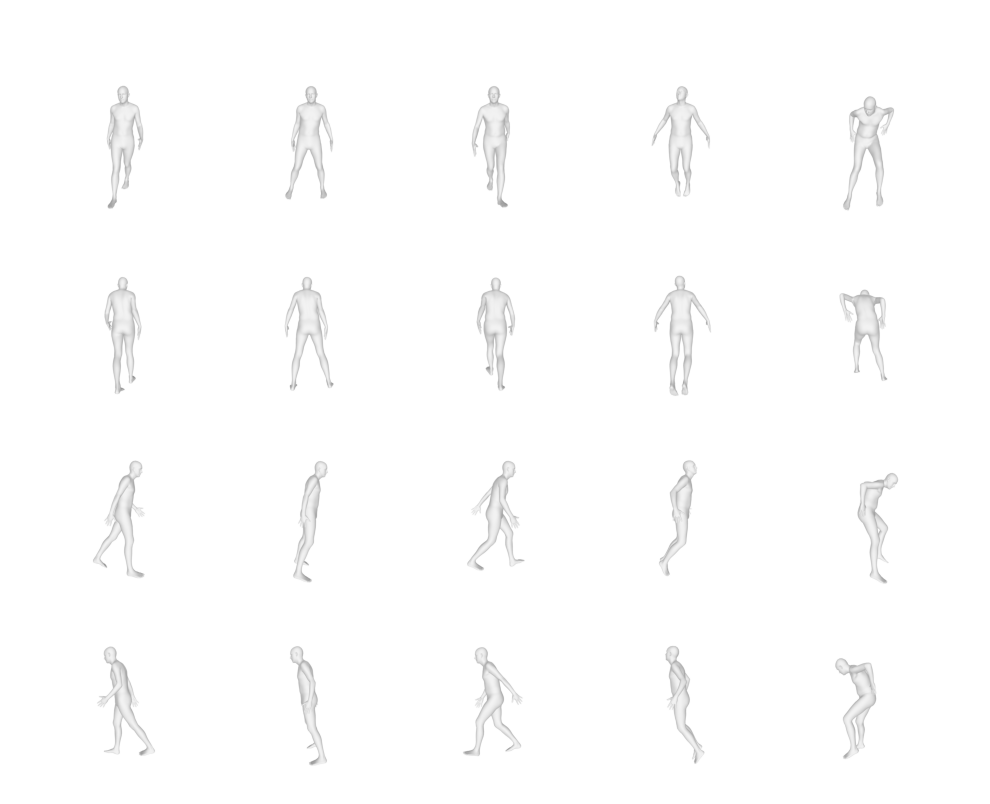

In [48]:
img = imagearray2file(images)
show_image(np.array(img)[0])

Each column in the above is a data point, and we rotate the body on each row to visualize it in different angles.
AMASS has recently been used to train a human body before raising a 2D-to-3D expressive human body image.

References:
- (https://smpl-x.is.tue.mpg.de/en)
- (https://github.com/nghorbani/human_body_prior)